这一章主要是TD(Temporal Difference)在强化学习中的东西

第四章中介绍的策略和价值迭代算法都要求交互环境完全已知, 这显然不现实.

对于大部分强化学习现实场景（例如电子游戏或者一些复杂物理环境），其马尔可夫决策过程的状态转移概率是无法写出来的，也就无法直接进行动态规划。在这种情况下，智能体只能和环境进行交互，通过采样到的数据来学习，这类学习方法统称为无模型的强化学习（model-free reinforcement learning）,这一部分是需要关注的重点

不同于动态规划算法，无模型的强化学习算法不需要事先知道环境的奖励函数和状态转移函数，而是直接使用和环境交互的过程中采样到的数据来学习

无模型强化学习主要有两大经典算法: **Sarsa**和**Q-learning**,二者都基于TD

同时，本章还会引入一组概念：**在线策略学习和离线策略学习**。通常来说，在线策略学习要求使用在当前策略下采样得到的样本进行学习，一旦策略被更新，当前的样本就被放弃了，就好像在水龙头下用自来水洗手；而离线策略学习使用经验回放池将之前采样得到的样本收集起来再次利用，就好像使用脸盆接水后洗手。因此，离线策略学习往往能够更好地利用历史数据，并具有更小的样本复杂度（算法达到收敛结果需要在环境中采样的样本数量），这使其被更广泛地应用

## 时序差分方法

结合了蒙特卡洛法和动态规划法的思想, 具体来说, 类似蒙特卡洛法的数据更新方式(从样本中学习)与类似DP用下一状态的价值更新当前状态的价值:

$$V(s_t)\leftarrow V(s_t)+\alpha[G_t-V(s_t)]$$

蒙特卡洛法中的 $\frac{1}{N(t)}$ 替换为了 $\alpha$ , 表示对价值估计更新的步长

蒙特卡洛方法必须要等整个序列结束之后才能计算得到这一次的回报 $G_t$ ，而时序差分方法只需要当前步结束即可进行计算

具体来说，时序差分算法用当前获得的奖励加上下一个状态的价值估计来作为在当前状态会获得的回报, 也即:

$$V(s_t)\leftarrow V(s_t)+\alpha[r_t+\gamma V(s_{t+1})-V(s_t)]$$

$r_t+\gamma V(s_{t+1})-V(s_t)$ 也被称为时序差分误差 TD error, 这两者可以代替的原因为:

\begin{aligned}V_{\pi}(s)&=\mathbb{E}_\pi[G_t|S_t=s]\\&=\mathbb{E}_\pi[\sum_{k=0}^\infty\gamma^kR_{t+k}|S_t=s]\\&=\mathbb{E}_\pi[R_t+\gamma\sum_{k=0}^\infty\gamma^kR_{t+k+1}|S_t=s]\\&=\mathbb{E}_\pi[R_t+\gamma V_\pi(S_{t+1})|S_t=s]\end{aligned}

因此蒙特卡洛方法将上式第一行作为更新的目标，而时序差分算法将上式最后一行作为更新的目标。

于是，在用策略和环境交互时，每采样一步，我们就可以用时序差分算法来更新状态价值估计

### Sarsa算法

策略迭代的改版, TD已经实现了策略评估, 那么只需要在未知奖励函数和状态转移函数的情况下实现策略提升即可

参考上面TD估计V的方式, 也可以直接对Q进行估计:

$$Q(s_t,a_t)\leftarrow Q(s_t,a_t)+\alpha[r_t+\gamma Q(s_{t+1},a_{t+1})-Q(s_t,a_t)]$$

然后就用贪婪算法对策略进行更新, 为了跳出局部极值, 需要使用 $\epsilon$-贪婪策略:

$$\pi(a|s)=\begin{cases}\epsilon/|\mathcal{A}|+1-\epsilon&\text{如果}a=\arg\max_{a^{\prime}}Q(s,a^{\prime})\\\epsilon/|\mathcal{A}|&\text{其他动作}&\end{cases}$$

现在，我们就可以得到一个实际的基于时序差分方法的强化学习算法。这个算法被称为 Sarsa,因为它的动作价值更新用到了当前状态$s$、当前动作$a$、 获得的奖励$r$、下一个状态$s^\prime$和下一个动作$a^{\prime}$,将这些符号拼接后就得到了算法名称。Sarsa 的具体算法如下：

· 初始化$Q(s,a)$

· for 序列$e=1\to E$ do :

.      得到初始状态$s$

.      用$\epsilon$-greedy 策略根据$Q$选择当前状态$s$下的动作$a$

.      for 时间步$t=1\to T$ do:

.      得到环境反馈的$r,s^\prime$

.      用$\epsilon$-greedy 策略根据$Q$选择当前状态$s^\prime$下的动作$a^{\prime}$

$$\begin{aligned}&Q(s,a)\leftarrow Q(s,a)+\alpha[r+\gamma Q(s^\prime,a^\prime)-Q(s,a)]\\&s\leftarrow s^{\prime},a\leftarrow a^{\prime}\end{aligned}$$

.      end for

. end for

下面, 仍然在悬崖漫步环境下测试Sarsa算法, 此时环境中不需要显式提供奖励函数和状态转移函数

In [76]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # tqdm是显示循环进度条的库


class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0  # 记录当前智能体位置的横坐标
        self.y = self.nrow - 1  # 记录当前智能体位置的纵坐标

    def step(self, action):  # 外部调用这个函数来改变当前位置
        # 4种动作, change[0]:上, change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0)
        # 定义在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False
        if self.y == self.nrow - 1 and self.x > 0:  # 下一个位置在悬崖或者目标
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self):  # 回归初始状态,坐标轴原点在左上角
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x  # 初始状态的编号

In [77]:
class Sarsa:
    """ Sarsa算法 """
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])  # 初始化Q(s,a)表格
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数
    
    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        
        return action

    def best_action(self, state):  # 用于打印策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):  # 若两个动作的价值一样,都会记录下来
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    def update(self, s0, a0, r, s1, a1):
        td_error = r + self.gamma * self.Q_table[s1, a1] - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 6061.66it/s, episode=500, return=-18.900]


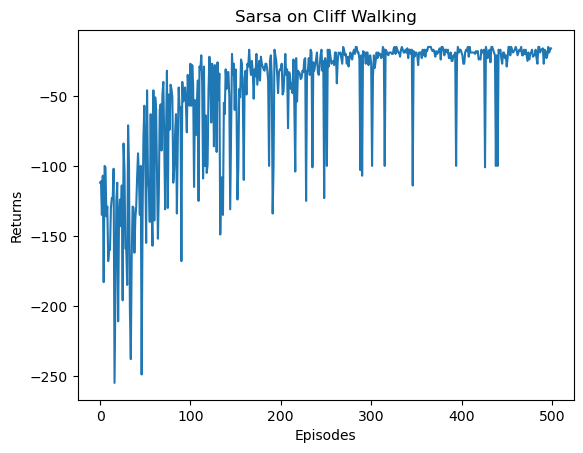

In [78]:
"""使用Sarsa算法"""

ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = Sarsa(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500  # 智能体在环境中运行的序列的数量

return_list = []  # 记录每一条序列的回报
for i in range(10):  # 显示10个进度条
    # tqdm的进度条功能
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False
            while not done:
                next_state, reward, done = env.step(action)
                next_action = agent.take_action(next_state)
                episode_return += reward  # 这里回报的计算不进行折扣因子衰减
                agent.update(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Sarsa on {}'.format('Cliff Walking'))
plt.show()

In [79]:
def print_agent(agent, env, action_meaning, disaster=[], end=[]):
    for i in range(env.nrow):
        for j in range(env.ncol):
            if (i * env.ncol + j) in disaster:
                print('****', end=' ')
            elif (i * env.ncol + j) in end:
                print('EEEE', end=' ')
            else:
                a = agent.best_action(i * env.ncol + j)
                pi_str = ''
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                print(pi_str, end=' ')
        print()


action_meaning = ['^', 'v', '<', '>']
print('Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

Sarsa算法最终收敛得到的策略为：
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ooo> ^ooo ooo> ooo> ooo> ooo> ^ooo ^ooo ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


蒙特卡洛: 无偏, 方差大(考虑当前状态之后的每一步奖励,不用价值估计)

Sarsa: 有偏, 方差小(只用一步奖励和下一个状态的价值估计)

考虑多布Sarsa, 将二者的优点结合起来:

\begin{aligned}&Q(s_t,a_t)\leftarrow Q(s_t,a_t)+\alpha[r_t+\gamma Q(s_{t+1},a_{t+1})-Q(s_t,a_t)]\\&Q(s_t,a_t)\leftarrow Q(s_t,a_t)+\alpha[r_t+\gamma r_{t+1}+\cdots+\gamma^nQ(s_{t+n},a_{t+n})-Q(s_t,a_t)]\end{aligned}

上面的是单步Sarsa, 下面的是多步Sarsa的更新公式

In [80]:
class nstep_Sarsa:
    """ n步Sarsa算法 """
    def __init__(self, n, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])
        self.n_action = n_action
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.n = n  # 采用n步Sarsa算法
        self.state_list = []  # 保存之前的状态
        self.action_list = []  # 保存之前的动作
        self.reward_list = []  # 保存之前的奖励

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def best_action(self, state):  # 用于打印策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a
    
    def update(self, s0, a0, r, s1, a1, done):
        self.state_list.append(s0)
        self.action_list.append(a0)
        self.reward_list.append(r)
        if len(self.state_list) == self.n:
            G = self.Q_table[s1, a1]
            for i in reversed(range(self.n)):
                G = self.gamma * G + self.reward_list[i]
                # 到达终止状态就不能更新n个了
                if done and i > 0:
                    s = self.state_list[i]
                    a = self.action_list[i]
                    self.Q_table[s, a] +=  self.alpha * (G - self.Q_table[s, a])
            s = self.state_list.pop(0)  # 将需要更新的状态动作从列表中删除,下次不必更新
            a = self.action_list.pop(0)
            self.reward_list.pop(0)
            # n步Sarsa的主要更新步骤
            self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])
        if done:  # 如果到达终止状态,即将开始下一条序列,则将列表全清空
            self.state_list = []
            self.action_list = []
            self.reward_list = []

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 3106.57it/s, episode=500, return=-19.100]


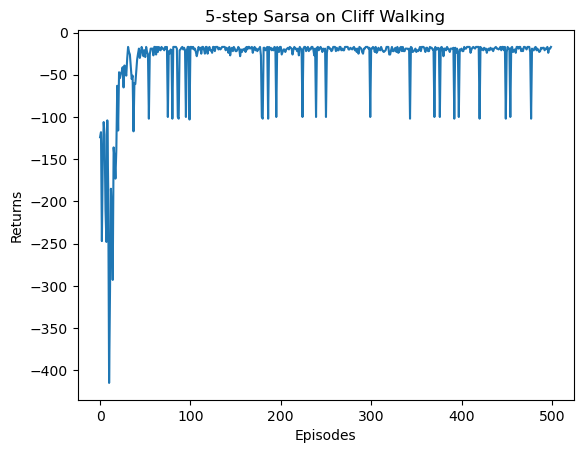

5步Sarsa算法最终收敛得到的策略为：
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ^ooo ^ooo oo<o ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ovoo 
ooo> ^ooo ^ooo ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


In [81]:
np.random.seed(0)
n_step = 5  # 5步Sarsa算法
alpha = 0.1
epsilon = 0.1
gamma = 0.9
agent = nstep_Sarsa(n_step, ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500  # 智能体在环境中运行的序列的数量

return_list = []  # 记录每一条序列的回报
for i in range(10):  # 显示10个进度条
    #tqdm的进度条功能
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False
            while not done:
                next_state, reward, done = env.step(action)
                next_action = agent.take_action(next_state)
                episode_return += reward  # 这里回报的计算不进行折扣因子衰减
                agent.update(state, action, reward, next_state, next_action,
                             done)
                state = next_state
                action = next_action
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('5-step Sarsa on {}'.format('Cliff Walking'))
plt.show()

action_meaning = ['^', 'v', '<', '>']
print('5步Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

## Q-learning算法

与Sarsa的最大区别在于其时序差分更新方式: 
 
$$Q(s_t,a_t)\leftarrow Q(s_t,a_t)+\alpha[R_t+\gamma\max_aQ(s_{t+1},a)-Q(s_t,a_t)]$$

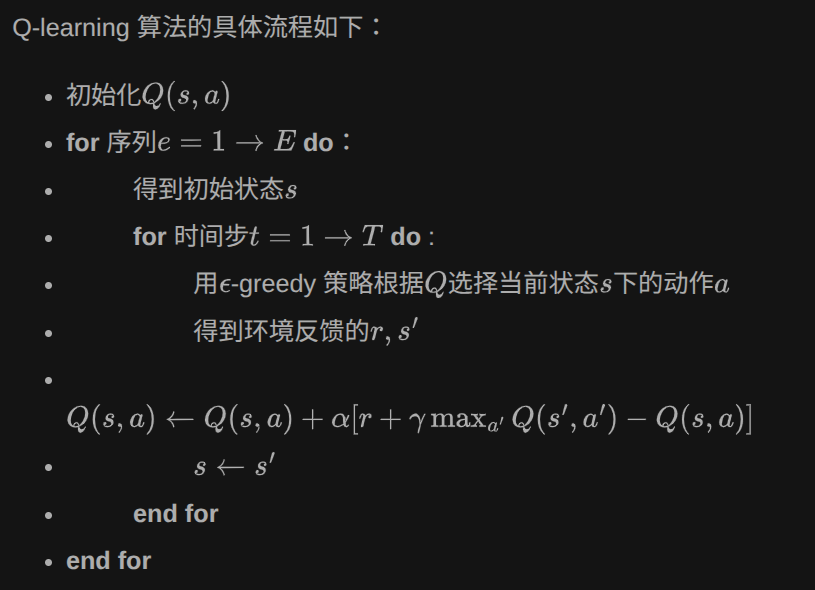

Q-learning相当于是在直接估计Q*, 而Sarsa估计的是当前的epsilon-贪婪策略动作价值函数

**我们称采样数据的策略为行为策略（behavior policy），称用这些数据来更新的策略为目标策略（target policy）。在线策略（on-policy）算法表示行为策略和目标策略是同一个策略；而离线策略（off-policy）算法表示行为策略和目标策略不是同一个策略。Sarsa 是典型的在线策略算法，而 Q-learning 是典型的离线策略算法。判断二者类别的一个重要手段是看计算时序差分的价值目标的数据是否来自当前的策略**

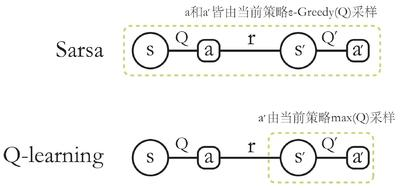

离线策略算法可以利用以往的数据, 具有更小的样本复杂度,因此更受欢迎

In [82]:
class QLearning:
    """ Q-learning算法 """
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])  # 初始化Q(s,a)表格
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数

    def take_action(self, state):  #选取下一步的操作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def best_action(self, state):  # 用于打印策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    def update(self, s0, a0, r, s1):
        td_error = r + self.gamma * self.Q_table[s1].max(
        ) - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 2330.89it/s, episode=500, return=-61.700]


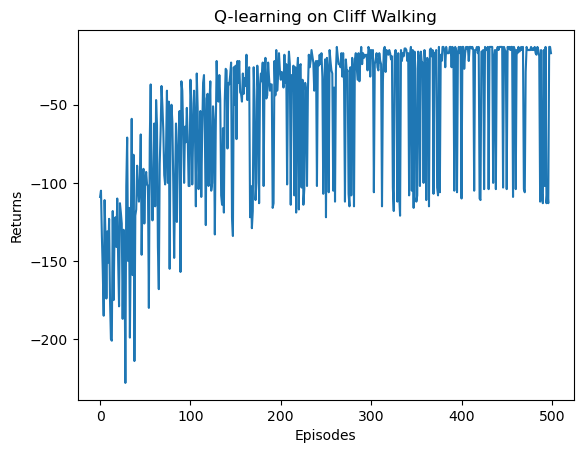

Q-learning算法最终收敛得到的策略为：
^ooo ovoo ovoo ^ooo ^ooo ovoo ooo> ^ooo ^ooo ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ^ooo ooo> ooo> ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


In [83]:
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = QLearning(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500  # 智能体在环境中运行的序列的数量

return_list = []  # 记录每一条序列的回报
for i in range(10):  # 显示10个进度条
    # tqdm的进度条功能
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
            episode_return = 0
            state = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done = env.step(action)
                episode_return += reward  # 这里回报的计算不进行折扣因子衰减
                agent.update(state, action, reward, next_state)
                state = next_state
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Q-learning on {}'.format('Cliff Walking'))
plt.show()

action_meaning = ['^', 'v', '<', '>']
print('Q-learning算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

Q-learning相比Sarsa更倾向于冒险, 其跌落悬崖的可能性也就更高, 因此期望回报看起来不如Sarsa